In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pprint
import numpy as np
import os
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.gridspec import GridSpec
device = torch.device("cpu")            
from extract_data import *

In [2]:
X_data, y_data = create_dataframes()

In [3]:
df_corr = pd.DataFrame()
for column in y_data:
    corrM = X_data.join(y_data[column]).corr()
    corrM.drop(corrM.tail(1).index,inplace=True)
    df_corr[column] = corrM[column]

df_corr = df_corr.T
df_corr

,WS,Wdir,Delta T,p140209,msl,t2m,d2m,blh,sst,chnk,ssr,month
WS 40m,0.962580,0.056202,-0.037145,0.022448,-0.206344,-0.172457,-0.161730,0.410736,-0.189806,0.530855,-0.108940,-0.051696
WS 57m,0.951707,0.054832,-0.020029,0.014973,-0.209202,-0.166127,-0.154084,0.406570,-0.192516,0.530396,-0.108120,-0.060123
WS 77m,0.940810,0.054939,-0.006381,0.008025,-0.211938,-0.160547,-0.147685,0.404326,-0.195268,0.530346,-0.106775,-0.066966
WS 97m,0.932843,0.055677,0.001790,0.002735,-0.214116,-0.156652,-0.143227,0.404060,-0.197461,0.531089,-0.105499,-0.071202
WS 117m,0.926523,0.056475,0.008007,-0.001786,-0.215435,-0.153157,-0.139339,0.404111,-0.198920,0.532066,-0.104665,-0.073964
WS 137m,0.920922,0.056712,0.013130,-0.005586,-0.216315,-0.150151,-0.135964,0.403874,-0.200065,0.532769,-0.103706,-0.075780
WS 157m,0.916063,0.056748,0.017214,-0.008947,-0.217058,-0.147485,-0.133095,0.404001,-0.200589,0.533665,-0.103337,-0.076571
WS 177m,0.911754,0.057688,0.020273,-0.012046,-0.218251,-0.145436,-0.130836,0.405020,-0.200790,0.535067,-0.103945,-0.076427
WS 197m,0.907898,0.058215,0.022791,-0.014380,-0.219248,-0.144229,-0.129290,0.405963,-0.201181,0.536236,-0.104781,-0.076545


In [4]:
# Hyperparameters
num_epochs = 250
log_freq = 15
n_train = int(0.8 * len(X_data))

# Data loader
X_train = torch.from_numpy(X_data[:n_train].values).float().to(device)
y_train = torch.from_numpy(y_data[:n_train].values).float().to(device)
X_val = torch.from_numpy(X_data[n_train:].values).float().to(device)
y_val = torch.from_numpy(y_data[n_train:].values).float().to(device)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_val, y_val)

In [5]:
#wandb hyperparameter dictionary
sweep_configuration = {
    "method": "random",
    "name": "random_search",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": 
    {   
        "lr": {"min": 0.0001, "max": 0.1},
        "batch_size": {"values": [64, 128, 256, 512]},
        "neurons1": {"values": [10, 11, 12, 13, 14, 15, 16, 17, 18]},
        "neurons2": {"values": [10, 11, 12, 13, 14, 15, 16, 17, 18]},
        "activation": {"values": ["tanh", "sigmoid", "relu", "leakyrelu"]}
    },
    "run_cap": 150
}
pprint.pprint(sweep_configuration)
project_name = "cme216_final_project"
group_name = "randomsearch"
sweep_id = wandb.sweep(sweep_configuration, project=project_name)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'name': 'random_search',
 'parameters': {'activation': {'values': ['tanh',
                                          'sigmoid',
                                          'relu',
                                          'leakyrelu']},
                'batch_size': {'values': [64, 128, 256, 512]},
                'lr': {'max': 0.1, 'min': 0.0001},
                'neurons1': {'values': [10, 11, 12, 13, 14, 15, 16, 17, 18]},
                'neurons2': {'values': [10, 11, 12, 13, 14, 15, 16, 17, 18]}},
 'run_cap': 150}
Create sweep with ID: blkqzxbp
Sweep URL: https://wandb.ai/tsounack/cme216_final_project/sweeps/blkqzxbp


In [6]:
class Network(nn.Module):
    def __init__(self, neurons1, neurons2, activation):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(12, neurons1),
            activation,
            nn.BatchNorm1d(neurons1),
            nn.Linear(neurons1, neurons2),
            activation,
            nn.BatchNorm1d(neurons2),
            nn.Linear(neurons2, 9)
            )
        
    def forward(self,x):
        y_pred = self.network(x)
        return y_pred

In [ ]:
import time
t1 = time.time()
# ==============================================================================
# Training
# ==============================================================================
# Train the model
def train(config=None):
    # Initialize the new wandb run
    wandb.init(config=config, project=project_name, group=group_name) 
    config = wandb.config
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=config.batch_size,
                                                shuffle=True)
    total_step = len(train_loader)
    loss_list = []

    activation = None
    if config.activation == "tanh":
        activation = nn.Tanh()
    elif config.activation == "sigmoid":
        activation = nn.Sigmoid()
    elif config.activation == "relu":
        activation = nn.ReLU()
    else:
        activation = nn.LeakyReLU()

    model = Network(config.neurons1, config.neurons2, activation)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    for epoch in range(num_epochs):
        for i, (train_x, train_y) in enumerate(train_loader):
            # Run the forward pass
            model.train()
            output = model(train_x)
            loss = criterion(output, train_y)
            loss_list.append(loss.item())
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % log_freq == 0:
            # Calculate the validation loss
            model.eval()
            with torch.no_grad():
                X_val_pred = model(X_val)                    
                val_loss = criterion(X_val_pred, y_val)

            # diff_ = (X_val_pred - y_val.unsqueeze(1)).detach().cpu().numpy().squeeze()
            # diff_vec = np.reshape(diff_, (diff_.shape[0], -1))
            # val_l2_pt_error = np.mean(np.linalg.norm(diff_vec, axis=1) / np.linalg.norm(np.reshape(y_val.detach().cpu().numpy(), (y_val.shape[0], -1)), axis=1), axis=0) * 100
            # rel_error = 100 * np.linalg.norm(diff_vec, axis=1) / np.linalg.norm(np.reshape(y_val.detach().cpu().numpy(), (y_val.shape[0], -1)), axis=1)
            
            wandb.log({"val_loss": val_loss.item(), "train_loss": loss.item(), "epoch": epoch})
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], \
                    Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Save the model checkpoint (optional)
    save_path = os.path.join(wandb.run.dir, "model.ckpt")
    torch.save(model.state_dict(), save_path)

wandb.agent(sweep_id, train)
t2 = time.time()
print(f"Total time taken: {t2-t1}")
wandb.finish()

Best performance obtained with:
- activation: "leakyrelu"
- batch_size: 64
- lr: 0.0049603811225372675
- neurons1: 13
- neurons2: 15

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)
total_step = len(train_loader)
model = Network(13, 15, nn.LeakyReLU())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00496)
for epoch in range(num_epochs):
    for i, (train_x, train_y) in enumerate(train_loader):
        # Run the forward pass
        model.train()
        output = model(train_x)
        loss = criterion(output, train_y)
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

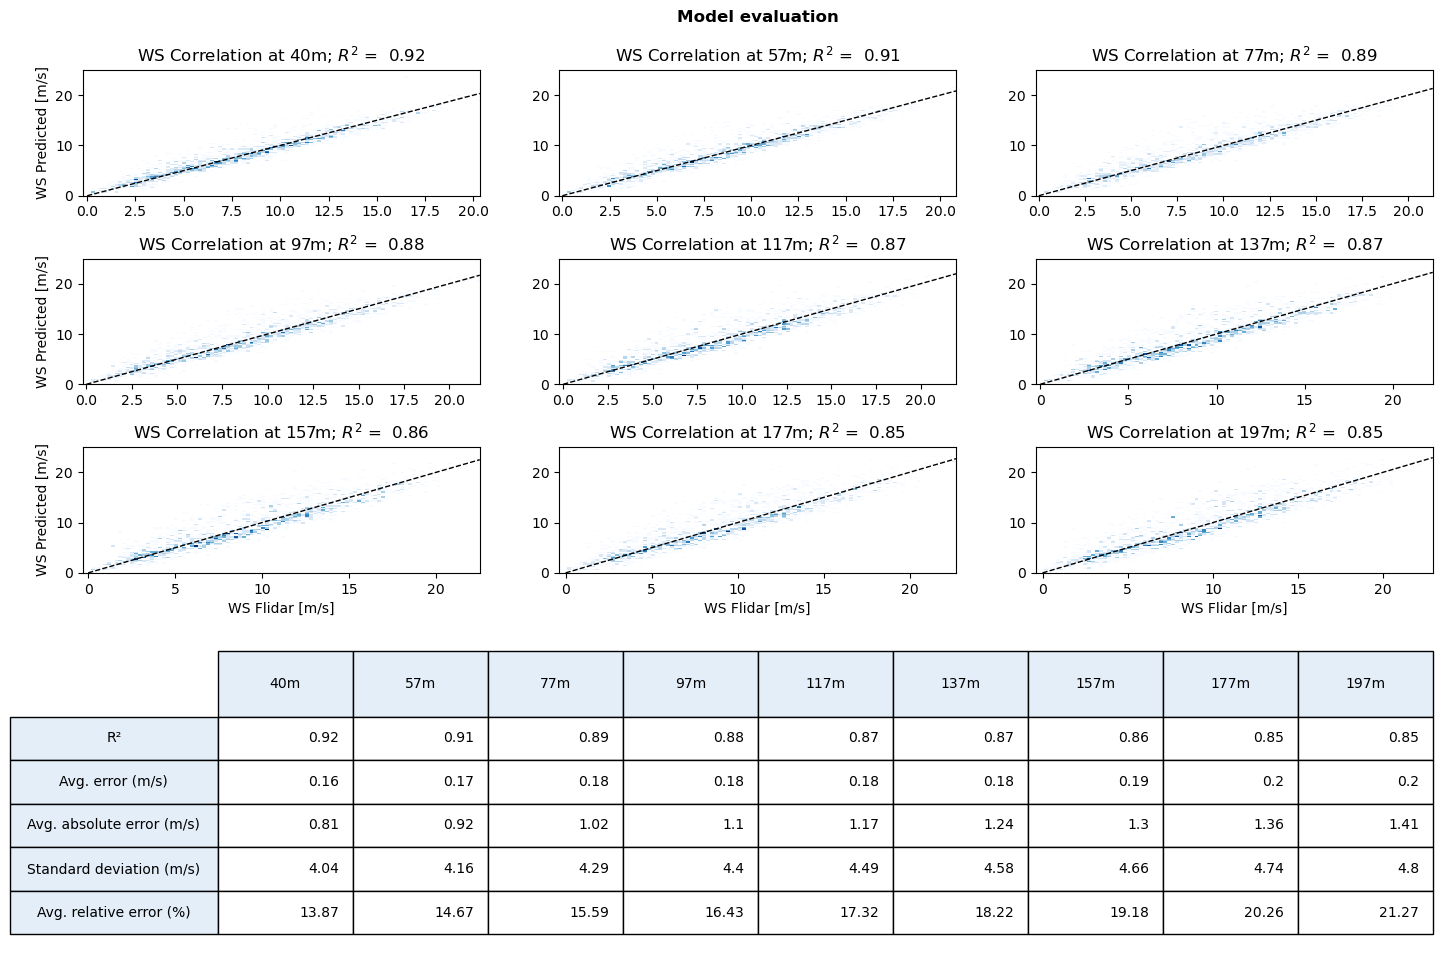

In [27]:
heights = [40,57,77,97,117,137,157,177,197]

df_X = pd.DataFrame(model(X_val).detach().numpy())
df_y = pd.DataFrame(y_val.numpy())
df_X.columns = [f"WS {z}m" for z in heights]
df_y.columns = [f"WS {z}m" for z in heights]


fig = plt.figure(figsize=(15, 10))
fig.tight_layout(pad=3)
spec = GridSpec(int(np.ceil(len(y_val[0])/3))+2,3, figure=fig)
column_headers = []

row_headers = ["R²", "Avg. error (m/s)", "Avg. absolute error (m/s)", "Standard deviation (m/s)", "Avg. relative error (%)"]

cell_text = np.zeros((len(row_headers), len(heights)))

r = 0
c = 0

for i, z in enumerate(heights):
    
    if len(heights)%3 == 1:
        
        if c > 2 and i != len(heights)-1:
            c = 0
            r += 1
        
        if i == 9:
            c = 1
            r += 1
    
    if len(heights)%3 != 1:
    
        if c > 2:
            c = 0
            r += 1
    
    column_headers += [str(z)+"m"]
    
    
    # R² value
    lr = st.linregress(df_X[f"WS {z}m"], df_y[f"WS {z}m"]) #scipy stats built-in linear regression function
    
    cell_text[0][i] = '{: 0.2f}'.format(lr.rvalue**2)
    
    
    # Mean error
    df_subtract = df_y[f"WS {z}m"].subtract(df_X[f"WS {z}m"], axis = 0)
    subtract_avg = df_subtract.mean()
    
    cell_text[1][i] = '{: 0.2f}'.format(subtract_avg)
    
    
    # Mean absolute error
    df_subtract_abs = df_subtract.abs()
    subtract_abs_avg = df_subtract_abs.mean()
    
    cell_text[2][i] = '{: 0.2f}'.format(subtract_abs_avg)
    
    
    # Standard deviation
    cell_text[3][i] = '{: 0.2f}'.format(np.std(df_y[f"WS {z}m"]))
    
    
    # Average relative error
    df_relative_error = 100 * df_subtract_abs.divide(df_X[f"WS {z}m"], axis = 0)
    relative_error_avg = df_relative_error.mean()
    cell_text[4][i] = '{: 0.2f}'.format(relative_error_avg)
        
        
        
    ## Histogram
    
    ax = fig.add_subplot(spec[r, c])
    
    ax.hist2d(df_X[f"WS {z}m"], df_y[f"WS {z}m"], 100, cmin=0.0001, cmap='Blues') 
    
    if c == 0:
        ax.set_ylabel("WS Predicted [m/s]")

    if r == int(np.ceil(len(heights)/3))-1:
        ax.set_xlabel("WS Flidar [m/s]")
        
    
    ax.set_ylim([0, 25])
        
    xpoints = ypoints = ax.get_xlim()
    ax.axline((xpoints[0], ypoints[0]), (xpoints[1], ypoints[1]), linestyle='--', color='k', lw=1)
    
    # on the title, I write the height of the plot and the R2 value
    ax.set_title(f"WS Correlation at {z}m; $R^2$ = {lr.rvalue**2: 0.2f}")

    c += 1


rcolors = plt.cm.Blues(np.full(len(row_headers), 0.1))
ccolors = plt.cm.Blues(np.full(len(column_headers), 0.1))

ax = fig.add_subplot(spec[int(np.ceil(len(heights)/3)):int(np.ceil(len(heights)/3))+2, :])

ytable = ax.table(cellText=cell_text,
            rowLabels=row_headers,
            rowColours=rcolors,
            rowLoc='center',
            colColours=ccolors,
            colLabels=column_headers,
            loc='center',
            bbox=[0.1, 0.05, 0.9, 0.9])

ax.axis('tight')
ax.axis('off')

fig.suptitle("Model evaluation", fontweight="bold")


cellDict = ytable.get_celld()
for i in range(0, len(cell_text[0])):
    cellDict[(0,i)].set_height(.15)
    for j in range(1, len(cell_text)+1):
        cellDict[(j,i)].set_height(.1)

for i in range(1, len(cell_text)+1):
    cellDict[(i,-1)].set_height(.1)

fig.subplots_adjust(left=0.05, bottom=0.04, right=0.95, top=0.92, hspace=0.5, wspace=0.2)

plt.show()